# Лабораторная работа №8.
## Рекуррентные нейронные сети для анализа временных рядов

In [1]:
from tensorflow.python.keras.callbacks import EarlyStopping
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error

plt.rc('figure',figsize=(12,6))
plt.rc('font',size=13)

WINDOW_SIZE = 12
BATCH_SIZE = 256
EPOCHS = 50

In [2]:
#1. Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

data = pd.read_csv("./Sunspots.csv", index_col=0,
                   date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'), parse_dates=[1])
data.columns = ["date", "sunspot"]
data.head()

,date,sunspot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


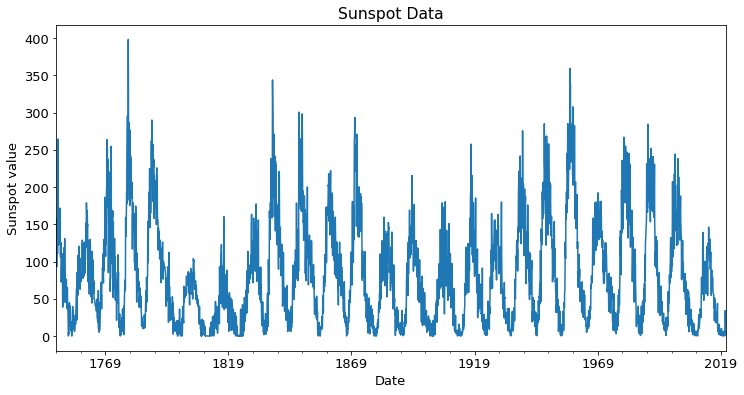

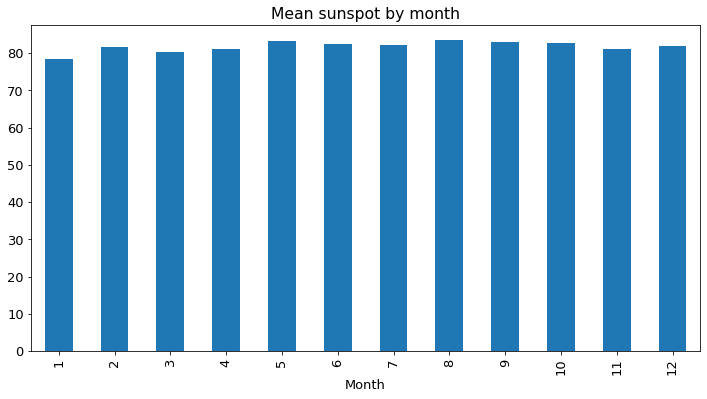

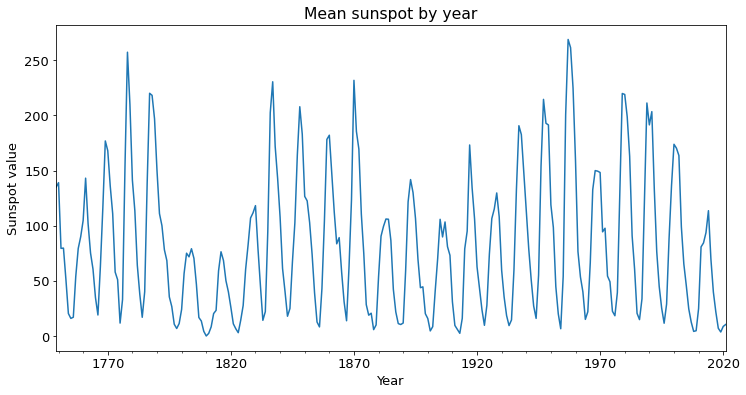

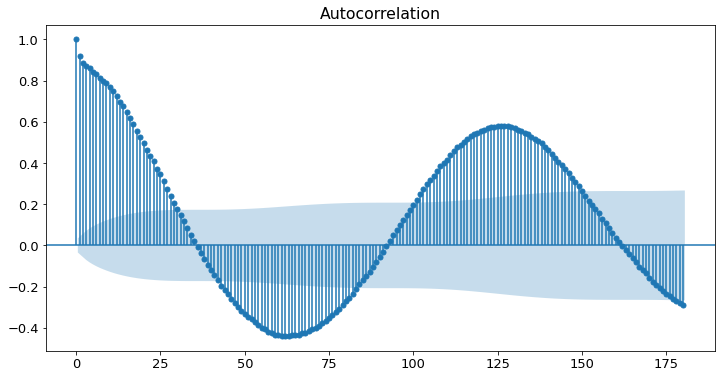

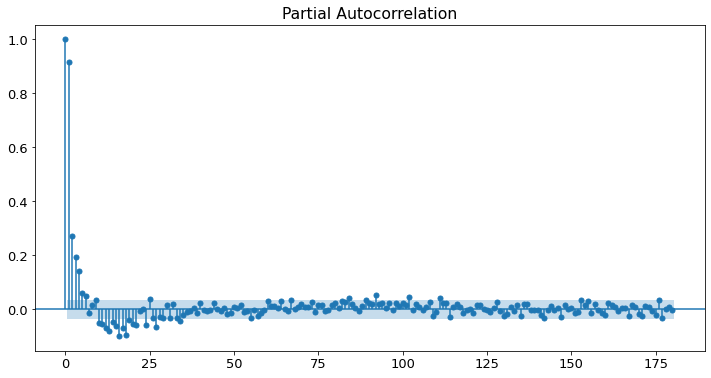

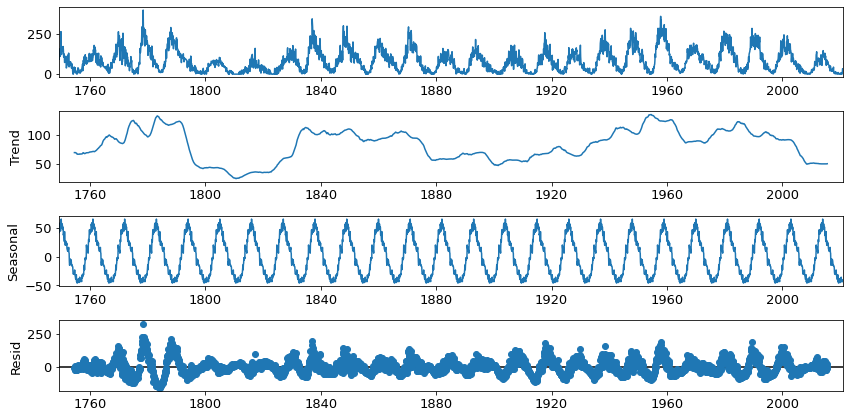

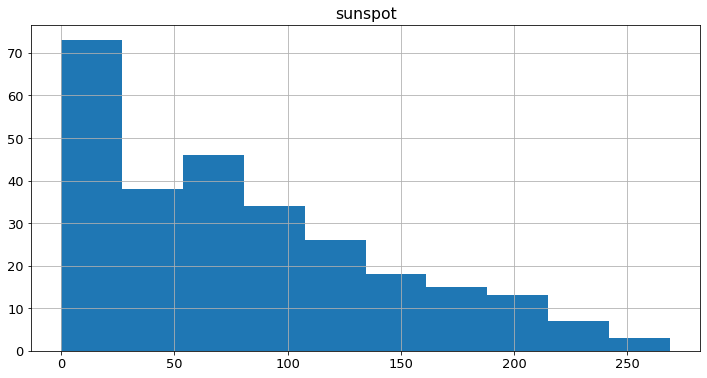

,sunspot
count,273.000000
mean,81.539103
std,63.345457
min,0.000000
25%,24.900000
50%,69.783333
75%,118.883333
max,268.841667


In [3]:
data.plot(x ="date", legend=False)
plt.title('Sunspot Data')
plt.xlabel('Date')
plt.ylabel('Sunspot value')
plt.show()

# Сезонность по месяцам не наблюдается
pd.concat([data["date"].dt.month, data["sunspot"]], axis=1).groupby("date").mean()["sunspot"].plot.bar()
plt.title('Mean sunspot by month')
plt.xlabel("Month")
plt.show()

# наблюдается цикличность и тренд
sunspot_per_month = data.set_index("date")
sunspot_per_year = sunspot_per_month.resample("Y").mean()
sunspot_per_year.plot(legend=False)
plt.title('Mean sunspot by year')
plt.xlabel('Year')
plt.ylabel('Sunspot value')
plt.show()

lag = 15*12
plot_acf(sunspot_per_month, lags=lag)
plt.show()

plot_pacf(sunspot_per_month, lags=lag)
plt.show()

lag = 11
res = seasonal_decompose(sunspot_per_month, period=lag*12)
res.plot()
plt.show()

sunspot = sunspot_per_year.describe()
sunspot_per_year.hist()
plt.show()
sunspot

In [4]:
# 2. Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

size = sunspot_per_month.size
train_last_index = int(size * 0.68)
valid_last_index = int(size * 0.84)

train = sunspot_per_month[: train_last_index]
valid = sunspot_per_month[train_last_index : valid_last_index]
test = sunspot_per_month[valid_last_index :]


In [5]:
# 3. Примените модель ARIMA для прогнозирования значений данного временного ряда.

order = (4,0,1)

def train_model_and_predict(history, order):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    prediction = output[0]
    return prediction

100%|██████████| 522/522 [06:44<00:00,  1.29it/s]


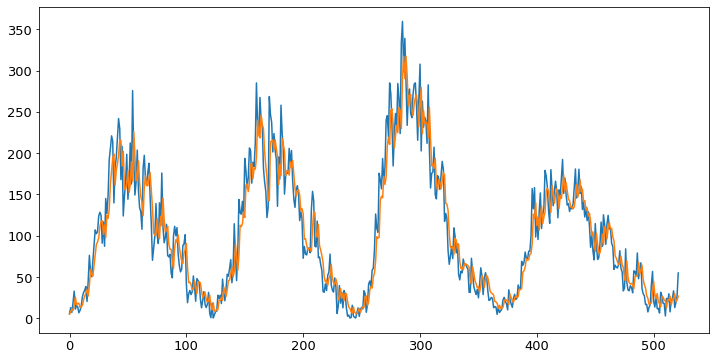

MSE Validation data 686.993670856751


In [6]:
history = [i for i in train.sunspot]
predictions = []

for value in tqdm(valid.sunspot):
    prediction = train_model_and_predict(history, order)
    history.append(value)
    predictions.append(prediction)

plt.plot(valid.sunspot.to_numpy())
plt.plot(predictions)
plt.show()

print("MSE Validation data", mean_squared_error(valid.sunspot.to_numpy(), predictions))

100%|██████████| 523/523 [07:55<00:00,  1.10it/s]


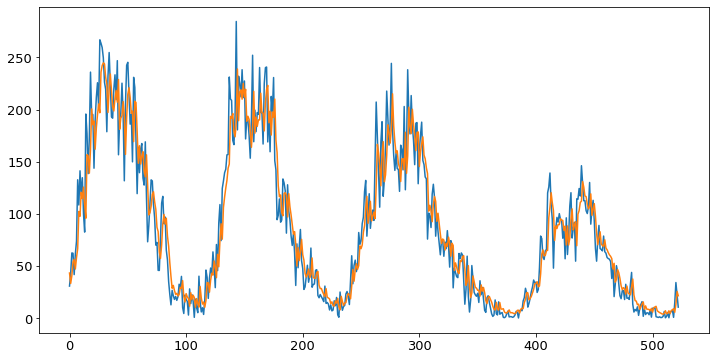

MSE Test data 566.8216395090047


In [7]:
predictions = []

for value in tqdm(test.sunspot):
    prediction = train_model_and_predict(history, order)
    history.append(value)
    predictions.append(prediction)

plt.plot(test.sunspot.to_numpy())
plt.plot(predictions)
plt.show()

print("MSE Test data", mean_squared_error(test.sunspot, predictions))

In [8]:
# 4. Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

loop_back = 3

def prepare_data(data):
    windowing = []
    data = data.sunspot
    for i in range(data.size - WINDOW_SIZE):
        a = data[i : (i + WINDOW_SIZE + 1)]
        windowing.append(a)
    windowing = np.array(windowing)
    X = windowing[:, : WINDOW_SIZE]
    Y = windowing[:, WINDOW_SIZE: ]
    return X[:, :, np.newaxis], Y[:, :, np.newaxis]

X_train, Y_train = prepare_data(train)
X_valid, Y_valid = prepare_data(valid)
X_test, Y_test = prepare_data(test)

In [9]:
def get_model():
    model = Sequential()
    model.add(InputLayer(input_shape=[WINDOW_SIZE, 1]))
    model.add(Conv1D(filters=60, kernel_size=5, padding="causal", activation="relu"))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(60, activation="relu"))
    model.add(Dense(60, activation="relu"))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam', metrics=["mae"])
    model.summary()
    return model

callbacks = [EarlyStopping(patience=10)]
model = get_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 60)            360       
_________________________________________________________________
lstm (LSTM)                  (None, 12, 100)           64400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 60)                6060      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 154,941
Trainable params: 154,941
Non-trainable params: 0
__________________________________________________

Epoch 1/50
9/9 [==============================] - 4s 64ms/step - loss: 9362.1553 - mae: 73.7325 - val_loss: 16029.1338 - val_mae: 100.5092
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 8494.1338 - mae: 68.4063 - val_loss: 14399.9336 - val_mae: 92.7762
Epoch 3/50
9/9 [==============================] - 0s 9ms/step - loss: 7211.6323 - mae: 61.5889 - val_loss: 12164.1025 - val_mae: 82.8711
Epoch 4/50
9/9 [==============================] - 0s 9ms/step - loss: 5747.8828 - mae: 54.8834 - val_loss: 9742.4668 - val_mae: 73.7200
Ep

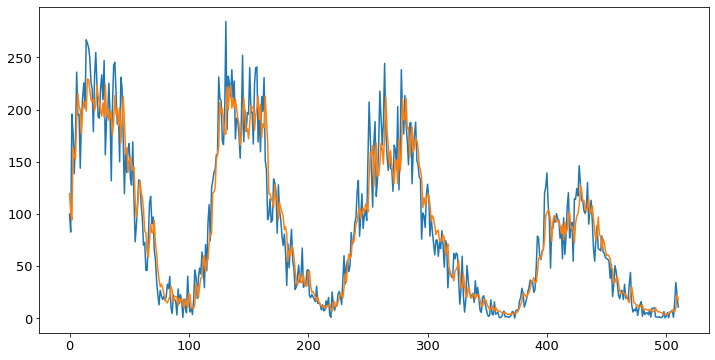

MSE Test data 553.5782303420681


In [10]:
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=BATCH_SIZE, callbacks=callbacks, epochs=EPOCHS)

prediction = model.predict(X_test).flatten()
test_prediction_true = test.sunspot[WINDOW_SIZE:].to_numpy()

plt.plot(test_prediction_true)
plt.plot(prediction)
plt.show()

print("MSE Test data", mean_squared_error(test_prediction_true, prediction).mean())

